**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=1_000, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(1000, 3) (1000,)


In [5]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

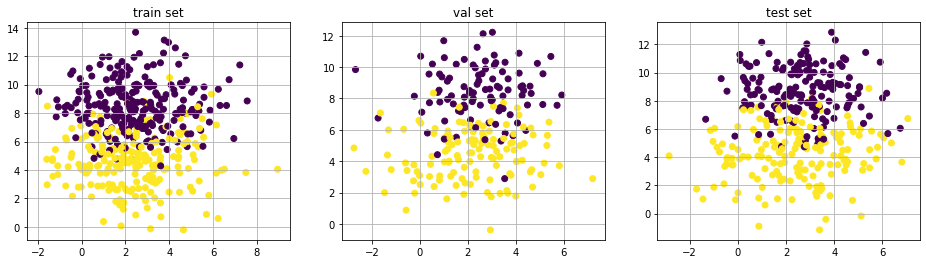

In [6]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [7]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## SLP + MSQE + GD

In [8]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [9]:
from lib.model.linear import SLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
    )
)

model.weight.shape

(3, 2)

In [10]:
from lib.loss.msqe import MSQE
loss_train = MSQE(model)
loss_val = MSQE(model)

In [11]:
from lib.optimizer.gd import GD 
from lib.optimizer.lrate import ConstLRA 

lra = ConstLRA(.01)

model = GD( 
    loss=loss_train, 
    loss_val=loss_val, 
    lra=lra,
).fit( 
    data_train=[X_train,y_train], 
    data_val=[X_val,y_val], 
    n_epoch=50,
)

100%|██████████| 50/50 [00:00<00:00, 600.18it/s, loss=0.523, lr=0.01]


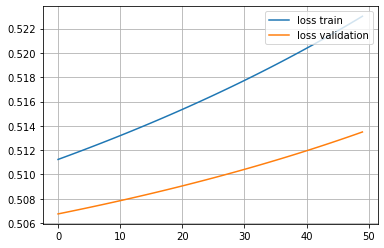

In [12]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.49      0.98      0.65       163

    accuracy                           0.48       330
   macro avg       0.24      0.49      0.33       330
weighted avg       0.24      0.48      0.32       330



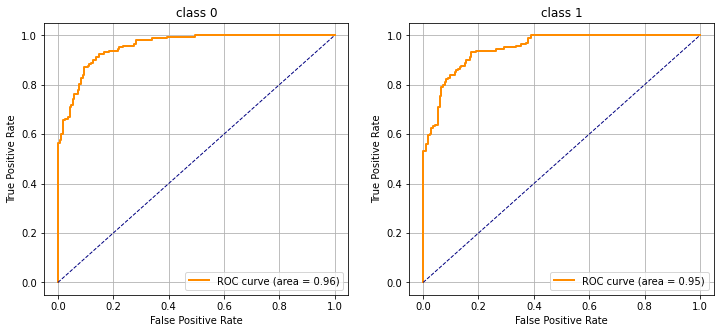

In [13]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [16]:
import pandas as pd

# pd.style.set_precision(precision=2)
# np.set_printoptions(precision=3)

s = model.score(X_train)
p = model.predict(X_train)

res = pd.DataFrame({
'y_true':y_train.tolist(),
'y_out':s.tolist(),
'target':target_train,
'predict':p,
'is_valid': target_train==p,
})

len(res.query('is_valid')) / len(res)

res

0.46205357142857145

,y_true,y_out,target,predict,is_valid
0,"[1.0, 0.0]","[0.40851914986469456, 0.4875960548606413]",0,1,False
1,"[0.0, 1.0]","[0.4578454613909336, 0.49284427620049936]",1,1,True
2,"[0.0, 1.0]","[0.46735613226529255, 0.4942559030448881]",1,1,True
3,"[1.0, 0.0]","[0.38928289840066355, 0.48523230581578475]",0,1,False
4,"[0.0, 1.0]","[0.45351686997058527, 0.4927022424390944]",1,1,True
...,...,...,...,...,...
443,"[1.0, 0.0]","[0.428353694840435, 0.4894808488035203]",0,1,False
444,"[0.0, 1.0]","[0.45633915488461924, 0.4927835036601885]",1,1,True
445,"[1.0, 0.0]","[0.40510275050074734, 0.486756183387639]",0,1,False
446,"[1.0, 0.0]","[0.41186120217857874, 0.48725999355475935]",0,1,False


## Softmax  + CCE + SGD

In [17]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {0,+1}

y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [18]:
from lib.model.linear import Softmax 
from lib.initiator.linear import NormalInitiatorLinearModel
# from lib.initiator.linear import UniformInitiatorLinearModel

model = Softmax(
    # initiator=UniformInitiatorLinearModel(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
    )
)

model.weight.shape

(3, 2)

In [19]:
from lib.loss.crossentropy import CCE # ф-ция потери - категориальная кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

In [20]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=255,
)

100%|██████████| 255/255 [00:00<00:00, 909.37it/s, loss=-.695, lr=0.01]


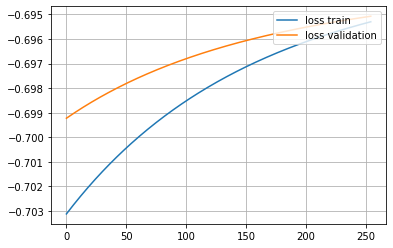

In [21]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

              precision    recall  f1-score   support

           0       0.07      0.05      0.06       167
           1       0.24      0.30      0.26       163

    accuracy                           0.17       330
   macro avg       0.15      0.17      0.16       330
weighted avg       0.15      0.17      0.16       330



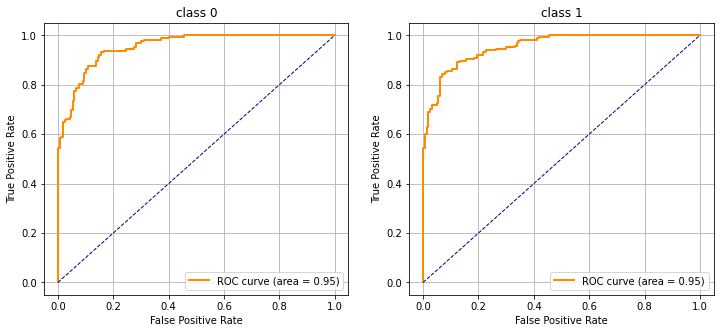

In [22]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

## LogisticRegression + BCE + SGD

In [23]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis] for t in [ target_train, target_val, target_test ] ]
# выход = метка класса

y_train.shape,y_val.shape,y_test.shape

((448, 1), (222, 1), (330, 1))

In [24]:
from lib.model.linear import SLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP( # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

model.weight.shape

(3, 1)

In [25]:
from lib.loss.crossentropy import BCE # ф-ция потери - кросс-энтропия
loss_train = BCE(model)
loss_val = BCE(model)

In [26]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
)

100%|██████████| 15/15 [00:00<00:00, 499.69it/s, loss=0.693, lr=0.01]


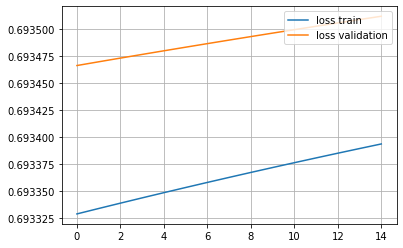

In [27]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

In [28]:
# target_train

In [29]:
from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
model.score_threshold

0.5021302600288747

In [30]:
# fig,ax = plt.subplots(1,1)
# ax.plot(range(10))

In [31]:
# model.score(X_val)

              precision    recall  f1-score   support

           0       0.50      0.47      0.48       167
           1       0.49      0.51      0.50       163

    accuracy                           0.49       330
   macro avg       0.49      0.49      0.49       330
weighted avg       0.49      0.49      0.49       330



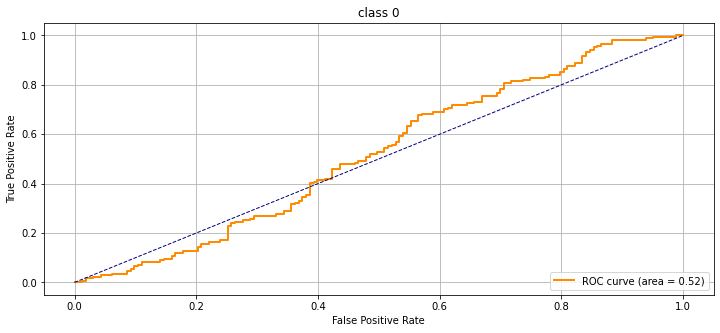

In [32]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

---

In [ ]:
# from lib.optimizer.lrate import FactorLRA # скорость обучения - уменьшается в процессе обучения
# # FactorLRA(start,bound,factor,)
# lra = FactorLRA(.5,bound=.01,factor=.9,)

In [ ]:
# from lib.optimizer.breaker import EarlyStopping # прерывание при достижении прога значения ф-ции потери
# # EarlyStopping( bound=None, min_delta=0., max_delta=None, patience=2 )
# es = EarlyStopping(bound=1e-2)

In [ ]:
# from lib.optimizer.regularizator import RegularizationL1 # регуляризация
# # RegularizationL1(rho)
# reg = RegularizationL1(rho=.01)

In [ ]:
# from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
# SGD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.)
# SGD.fit(data_train,batch_size, data_val=None,n_epoch=2,target_is_indices=False):

In [ ]:
# model = SGD(
#     loss=loss_train,
#     loss_val=loss_val,
#     lra=lra,
#     breaker=es,
#     regul=reg,
#     momentum=.01,    
# ).fit(
#     data_train=[X_train,y_train],
#     data_val=[X_val,y_val],
#     n_epoch=15,
#     batch_size=y_train.shape[0]//10,
# )

In [ ]:
# from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# # ClassifierEstimator(target,predict_score,loss_history)

# ClassifierEstimator(
#     target=target_test, 
#     predict_score=model.predict(X_test),  
#     loss_train_history=loss_train.history,
#     loss_val_history=loss_val.history, 
# ).estimate()

## LinearModel  + MSQE + GD

In [ ]:
# # преобразуем список меток к размерности выхода модели
# y_train = np.eye(target_train.max()+1)[target_train]
# y_val = np.eye(target_val.max()+1)[target_val]
# y_test = np.eye(target_test.max()+1)[target_test]
# y_train.shape,y_val.shape,y_test.shape

In [ ]:
# from lib.initiator.linear import UniformInitiatorLinearModel
# # UniformInitiatorLinearModel(input_size,output_size)

In [ ]:
# from lib.model.linear import LinearModel # простая линейная модель x.dot(w)
# # LinearModel(initiator)
# model = LinearModel(
#     initiator=UniformInitiatorLinearModel(
#     #initiator=NormalInitiatorLinearModel(
#         input_size=X_train.shape[1],
#         output_size=y_train.shape[1],
#     )
# )

# model.weight.shape

In [ ]:
# from lib.loss.msqe import MSQE # ф-ция потери - cреднеквадратическое отклонение
# loss_train = MSQE(model)
# loss_val = MSQE(model)

In [ ]:
# from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
# lra = ConstLRA(.01)

In [ ]:
# from lib.optimizer.gd import GD # метод оптимизации градиентный спуск
# # GD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.) 
# # GD.fit(data_train,data_val=None,n_epoch=2)

----

In [ ]:
# model._act_derivative(X_train)
# model._partial(X_train).shape

----

In [ ]:
# model = GD(
#     loss=loss_train,
#     loss_val=loss_val,
#     lra=lra,
# ).fit(
#     data_train=[X_train,y_train],
#     data_val=[X_val,y_val],
#     n_epoch=15,
# )

In [ ]:
# model.predict(X_test)[:,1]

In [ ]:
# from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# # ClassifierEstimator(target,predict_score,loss_history)

# ClassifierEstimator(
#     target=target_test, 
#     predict_score=model.predict(X_test)[:,1],  
#     loss_train_history=loss_train.history,
#     loss_val_history=loss_val.history, 
# ).estimate()

---

In [ ]:
## FactorLRA

In [ ]:
# from lib.optimizer.lrate import ConstLRA
# lr =  ConstLRA(.1)
# [ lr.next() for _ in range(100) ]
# lr.history

In [ ]:
# from lib.optimizer.lrate import FactorLRA
# lr =  FactorLRA(value=.9,bound=.01,factor=.9,)
# v = [ lr.next() for _ in range(100)] 
# plt.plot(lr.history)
# plt.grid()

---

In [ ]:
# model.predict(X_train).shape
# model._state(X_train).shape

# model._state_derivative(X_train).shape
# model._act_derivative( model._state(X_train) ).shape
# model._partial(X_train).shape

In [ ]:
# loss_train.estimate(X_train,y_train)
# loss_train.gradient(X_train,y_train).shape

In [ ]:
# d = rng.normal( size=(448,3,2) )
# p = rng.uniform( size=(448,2) )[:,np.newaxis,:]
# (p*d).sum(axis=0).shape

$$s=x\cdot w$$

$$ o = f(s) $$

$$\mathscr{L}(o,y) = \mathscr{L}\left(f(x\cdot w),y\right)$$

$$
\frac{ \partial \mathscr{L} }{ \partial w } 
= \frac{ \partial \mathscr{L} }{ \partial o }
\cdot \frac{ \partial f }{ \partial s }
\cdot \frac{ \partial s }{ \partial w }
$$

$$
\frac{ \partial f }{ \partial w } =
\frac{ \partial f }{ \partial s }
\cdot \frac{ \partial s }{ \partial w }
$$

In [ ]:
# state_d = rng.normal(size=(448,2))
# act_d = rng.uniform(size=(448,3))

# # (448, 3, 2)
# # np.swapaxes( act_d[:,np.newaxis],1,2).shape, state_d[:,np.newaxis].shape

# np.matmul( np.swapaxes( act_d[:,np.newaxis],1,2), state_d[:,np.newaxis] ).shape

# act_d.dot(state_d)


In [ ]:
# p = rng.normal( size=(448,3,2) )
# o = rng.uniform( size=(448,2) )[:,np.newaxis,:]
# t = rng.uniform( size=(448,2) )[:,np.newaxis,:]

# d = (1./o)*p
# d.shape

# g = (d*t).sum(axis=0)/len(t)
# g.shape


# # (p*d).sum(axis=0).shape

In [ ]:
#  def _gradient(self,input_data,target): 
#         o = self._model.predict(input_data)
#         p = self._model._partial(input_data)
#         with np.errstate(divide='ignore',invalid='ignore'):
#             d = np.where(o!=0.,(1./o)*p , 1. )
        
#         g = d.T.dot(target)/len(target)
        
#         g = 2.*(p*d).sum(axis=0)/len(d)

#         return self._norm(g)


---

In [ ]:
# model.predict(X_train).shape
# model._state(X_train).shape

# model._state_derivative(X_train).shape
# model._act_derivative( model._state(X_train) ).shape
# model._partial(X_train).shape

# loss_train.estimate(X_train,y_train)
# loss_train.gradient(X_train,y_train).shape

----

In [ ]:
# #from lib.optimizer.lrate import FactorLRA # скорость обучения - уменьшается в процессе обучения
# # FactorLRA(start,bound,factor,)
# # lra = FactorLRA(.5,bound=.01,factor=.9,)
# from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
# lra = ConstLRA(.01)

# #from lib.optimizer.breaker import EarlyStopping # прерывание при достижении прога значения ф-ции потери
# # EarlyStopping( bound=None, min_delta=0., max_delta=None, patience=2 )
# #es = EarlyStopping(bound=1e-2)

# from lib.optimizer.regularizator import RegularizationL1 # регуляризация
# # RegularizationL1(rho)
# reg = RegularizationL1(rho=.01)

# from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
# # SGD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.)
# # SGD.fit(data_train,batch_size, data_val=None,n_epoch=2,target_is_indices=False):

In [ ]:
# model = SGD(
#     loss=loss_train,
#     loss_val=loss_val,
#     lra=lra,
#     #breaker=es,
#     regul=reg,
#     momentum=.01,    
# ).fit(
#     data_train=[X_train,y_train],
#     data_val=[X_val,y_val],
#     n_epoch=15,
#     batch_size=y_train.shape[0]//10,
# )

In [ ]:
# from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# # ClassifierEstimator(target,predict_score,loss_history)

In [ ]:
# ClassifierEstimator(
#     target=target_test, 
#     predict_score=model.predict(X_test)[:,1],  
#     loss_train_history=loss_train.history, 
#     loss_val_history=loss_val.history, 
# ).estimate()